In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [3]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points.npy'))
REFERENCE_POINT_IDX = 0

### Wizualizacja wybranych punktów

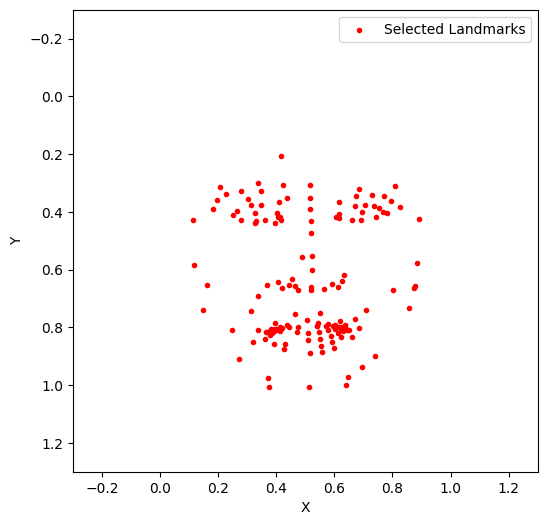

In [4]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)


### Zdobycie danych

In [5]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('ravdess')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

## Preprocessing danych

In [ ]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2012, 157, 154])
torch.Size([2012, 8])


# MODEL TORCH

### W podejściu wykorzystane zostaną 2 modele - pierwszy z nich będzie siecią konwolucyjną 2d, która będzie miała za zadanie nauczyć się rozpoznawać cechy charakterystyczne dla wybranej klatki (zbioru współrzędnych pkt charakterystycznych). Do klasyfikacji szeregu czasowego zostanie wykorzystana sekwencyjna sieć neuronowa LSTM.

## Zbudowanie modelu ekstrakcji cech

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, number_landmarks=LANDMARK_INDEXES.size):
        super(EmotionClassifier, self).__init__()

        self.number_landmarks = number_landmarks
        
        # Spatial feature extraction using Conv1D
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # in_channels=1 for distances
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the number of features after Conv1D and pooling
        # Conv1D output: (batch_size * frames, 32, number_landmarks)
        # Pool1D output: (batch_size * frames, 32, number_landmarks // 2)
        self.flattened_features = 32 * (number_landmarks // 2)
        
        # LSTM layers for temporal feature extraction
        self.lstm1 = nn.LSTM(input_size=self.flattened_features, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)  # 8 emotion classes

    def forward(self, x):
        # x shape: (batch_size, frames, number_landmarks)
        batch_size, frames, landmarks = x.shape
        
        # Reshape for Conv1D: (batch_size * frames, 1, landmarks)
        x = x.view(-1, landmarks).unsqueeze(1)  # Shape: (batch_size * frames, 1, number_landmarks)
        
        # Spatial feature extraction
        x = F.relu(self.conv1(x))  # Shape: (batch_size * frames, 32, number_landmarks)
        x = self.pool1(x)          # Shape: (batch_size * frames, 32, number_landmarks // 2)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # Shape: (batch_size, frames, 32 * (number_landmarks // 2))
        
        # Temporal feature extraction
        x, _ = self.lstm1(x)  # Shape: (batch_size, frames, 128 * 2)
        x, _ = self.lstm2(x)  # Shape: (batch_size, frames, 64)
        
        # Classification
        x = self.fc(x[:, -1, :])  # Take the last timestep's output; Shape: (batch_size, 8)
        return x

In [19]:
from torch.optim import Adam

model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Trening modelu

In [ ]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_path = os.path.join('runs', 'torch_lstm', 'emotion_classifier_landmark_distance_normalized')
writer = SummaryWriter(writer_path)

In [ ]:
from utils.model_functions import train_torch_model_multiclass

train_torch_model_multiclass(model, criterion, optimizer, X_train, y_train, X_val, y_val, writer)

Epoch 1/300, Train Loss: 130.3990, Train Acc: 0.1163, Val Loss: 28.8660, Val Acc: 0.1253
Epoch 2/300, Train Loss: 130.2130, Train Acc: 0.1228, Val Loss: 28.8656, Val Acc: 0.1369
Epoch 3/300, Train Loss: 130.0731, Train Acc: 0.1292, Val Loss: 28.8575, Val Acc: 0.1276
Epoch 4/300, Train Loss: 130.0769, Train Acc: 0.1342, Val Loss: 28.8621, Val Acc: 0.1276
Epoch 5/300, Train Loss: 130.0955, Train Acc: 0.1317, Val Loss: 28.8730, Val Acc: 0.1276
Epoch 6/300, Train Loss: 130.0726, Train Acc: 0.1347, Val Loss: 28.8638, Val Acc: 0.1323
Epoch 7/300, Train Loss: 130.0215, Train Acc: 0.1243, Val Loss: 28.8596, Val Acc: 0.1276
Epoch 8/300, Train Loss: 130.0310, Train Acc: 0.1302, Val Loss: 28.8648, Val Acc: 0.1276
Epoch 9/300, Train Loss: 130.0468, Train Acc: 0.1387, Val Loss: 28.8616, Val Acc: 0.1276
Epoch 10/300, Train Loss: 130.0321, Train Acc: 0.1287, Val Loss: 28.8663, Val Acc: 0.1276
Epoch 11/300, Train Loss: 130.0624, Train Acc: 0.1208, Val Loss: 28.8605, Val Acc: 0.1276
Epoch 12/300, Train

KeyboardInterrupt: 

## Ewaluacja modelu

In [ ]:
from utils.model_functions import eval_torch_model_multiclass

eval_torch_model_multiclass(model, criterion, X_test, y_test)

Test Loss: 0.0589, Test Accuracy: 0.2847
